# Generating Adversarial Examples using PyTorch

<p style="font-size:18px; font-family:open sans; line-height:1.2">
Deep Neural Networks are found to be vulnerable to something called adversarial examples. Adversarial examples are maliciouly designed inputs which are perceptually indistinguishable from original input but are misclassfied by the model. Adversarial examples have gained a lot of attention by research community and as a result we have got several methods to generate adversarial examples. This notebook implements and explains 4 simple methods to generate adversarial examples. We will start by installing necessary libs, loading input image and classifying it using pre-trained inceptionv3 model. Then, we will move on to these methods.

<p style="font-size:18px; font-family:open sans; line-height:1.2">
First of all, install necessary libraries by running following commands. I assume you have already installed numpy, matplotlib and requests. Restart the runtime once you have installed them.</p>
<pre><code>
    !pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.1-cp36-cp36m-linux_x86_64.whl 
    !pip3 install torchvision
    !pip3 install --no-cache-dir -I pillow
</code></pre>

In [0]:
#import required libs
import torch
import torch.nn
from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

<p style="font-size:18px; font-family:open sans; line-height:1.2">Here, we will use pre-trained inceptionv3 model. You can use VGG or any other model you want. But you have to make some changes in this code (i.e input size). Since inceptionv3 uses dropout and batch normalization whose behavior at evaluation time differs from the train time, we need to set it to the `eval()` mode.</p>

In [0]:
inceptionv3 = models.inception_v3(pretrained=True) #download and load pretrained inceptionv3 model
inceptionv3.eval();


<p style="font-size:18px; font-family:open sans">Next, we will load an image using requests and PIL. Feel free to use image of your choice.</p>

In [0]:
url = "https://savan77.github.io/blog/images/ex4.jpg"  #tiger cat
response = requests.get(url)
img = Image.open(io.BytesIO(response.content))

<p style="font-size:18px; font-family:open sans; line-height:1.2">Now, we need to preprocess the input image before passing it through inceptionv3 model. Since we loaded this image using PIL, we have to convert it into a torch tensor. We also need to reshape our input image. Inceptionv3 expects height and weight of the input to be 299. Finally, we will perform normalization. Note that inceptionv3 model of pytorch uses pre-trained weights from Google and they expect inputs with pixel values in between -1 to 1. PyTorch performs this ops internally and it expects inputs normalized with below given mean and standard deviation(for the sake of uniformity). If you want to implement normalization (as assumed by pre-trained weights from Google) manually then you have to pass one more parameter ( `transform_input=False` ) while loading the pre-trained inceptionv3 model. For example, `inceptionv3 = models.inception_v3(pretrained=True, transform_input=False)`. `Compose()` makes it very easy to combine multiple transformations in one function.



In [0]:
#mean and std will remain same irresptive of the model you use
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

preprocess = transforms.Compose([
                transforms.Resize((299,299)),  
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

<p style="font-size:18px; font-family:open sans; line-height:1.2">Next, we will preprocess our input image using the function created above.

In [0]:
image_tensor = preprocess(img) #preprocess an i
image_tensor = image_tensor.unsqueeze(0) # add batch dimension.  C X H X W ==> B X C X H X W

In [0]:
img_variable = Variable(image_tensor, requires_grad=True) #convert tensor into a variable


<p style="font-size:18px; font-family:open sans; line-height:1.2">Next, we will classify this image using pre-trained inceptionv3 model that we just loaded.

In [28]:
output = inceptionv3.forward(img_variable)
label_idx = torch.max(output.data, 1)[1][0]   #get an index(class number) of a largest element
print(label_idx)

282


<p style="font-size:18px; font-family:open sans; line-height:1.2">Next, we will create a dictionary to map index to imagenet class. ImageNet has 1000 classes.

In [29]:
labels_link = "https://savan77.github.io/blog/files/labels.json"    
labels_json = requests.get(labels_link).json()
labels = {int(idx):label for idx, label in labels_json.items()}
x_pred = labels[label_idx]
print(x_pred)

tiger cat


<p style="font-size:18px; font-family:open sans; line-height:1.2">Note that `forward()` method returns logits. So in order to get probability distribution over 1000 classes, we need to pass `output` through a softmax function.

In [30]:
#get probability dist over classes
output_probs = F.softmax(output, dim=1)
x_pred_prob =  round((torch.max(output_probs.data, 1)[0][0]) * 100,4)
print(x_pred_prob)

74.9844


# Fast Gradient Sign Method

<p style="font-size:18px; font-family:open sans; line-height:1.5">Let's say we have an input X, which is correctly classified by our model (M). We want to find an adversarial example $\hat{X}$, which is perceptually indistinguishable from original input X, such that it will be misclassified by that same model (M). We can do that by adding an adversarial perturbation ( $\theta$ ) to the original input. Note that we want adversarial example to be indistinguishable from the original one. That can be achieved by constraining the magnitude of adversarial perturbation: $||X - \hat{X}||_{\infty} \leqslant \epsilon$. That is, the $L_{\infty}$ norm should be less than epsilon. Here, $L_{\infty}$ denotes the maximum changes for all pixels in adversarial example. Fast Gradient Sign Method (FGSM) is a fast and computationally efficient method to generate adversarial examples. However, it usually has a lower success rate. The formula to find adversarial example is as follows:
$$ X^{adv} = X + \epsilon sign(\nabla_X J(X, Y_{true})$$
Here, <br>
X = original (clean) input <br>
$ X_{adv}$ = adversarial input (intentionally designed to be misclassified by our model) <br>
$ \epsilon $ = magnitude of adversarial perturbation  <br>
$ \nabla_X J(X, Y_{true}) $ = gradient of loss function w.r.t to input (X)


In [31]:
y_true = 282   #tiger cat  ##change this if you change input image
target = Variable(torch.LongTensor([y_true]), requires_grad=False)
print(target)

Variable containing:
 282
[torch.LongTensor of size 1]



In [0]:
#perform a backward pass in order to get gradients
loss = torch.nn.CrossEntropyLoss()
loss_cal = loss(output, target)
loss_cal.backward(retain_graph=True)    #this will calculate gradient of each variable (with requires_grad=True) and can be accessed by "var.grad.data"

<p style="font-size:18px; font-family:open sans; line-height:1.2">
Following code cell computes the adversarial example using formula shown above.

In [0]:
eps = 0.02
x_grad = torch.sign(img_variable.grad.data)                #calculate the sign of gradient of the loss func (with respect to input X) (adv)
x_adversarial = img_variable.data + eps * x_grad          #find adv example using formula shown above
output_adv = inceptionv3.forward(Variable(x_adversarial))   #perform a forward pass on adv example
x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0]]    #classify the adv example
op_adv_probs = F.softmax(output_adv, dim=1)                 #get probability distribution over classes
adv_pred_prob =  round((torch.max(op_adv_probs.data, 1)[0][0]) * 100, 4)      #find probability (confidence) of a predicted class


In [34]:
print(x_adv_pred)
print(adv_pred_prob)

Egyptian cat
66.0086


<p style="font-size:18px; font-family:open sans; line-height:1.2">Finally, we generated an adversarial example which was misclassified by our model. Since Egyptian cat look somewhat similar to tiger cat, it's not that great. We still need to do better. Next, we define a function which visualizes original input, adversarial input and adversarial perturbation. This will give us a better understanding of how adversarial examples look like, are they indistinguishable from odiginal input or not. 

In [0]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    x = np.transpose( x , (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()

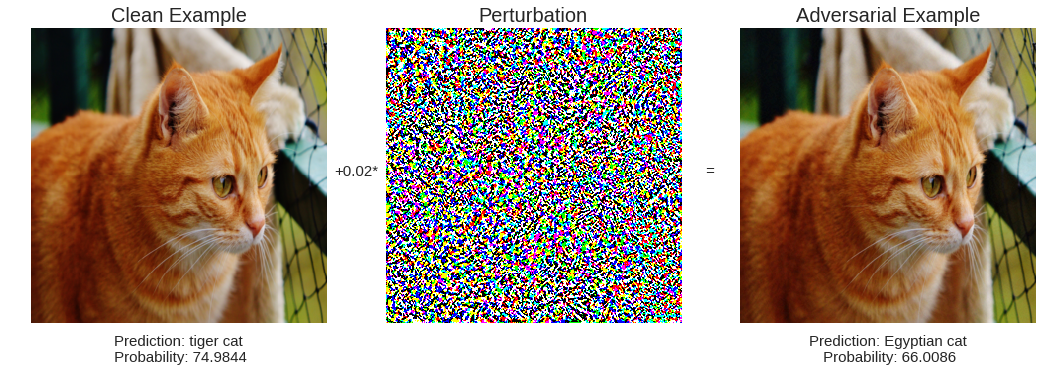

In [36]:
visualize(image_tensor, x_adversarial, x_grad, eps, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)

<p style="font-size:18px; font-family:open sans; line-height:1.2">As you can see, the generated adversarial image is visually indistinguishable from the original image but inceptionv3 classifies it as Egyptian cat. Now, let us generate several adversarial images with different values of epsilon. Notice that as we increase the value of epsilon the adversarial image becomes distinguishable from the original one.

In [0]:
epsilon = [0.00088, 0.004, 0.01, 0.12, 0.55]

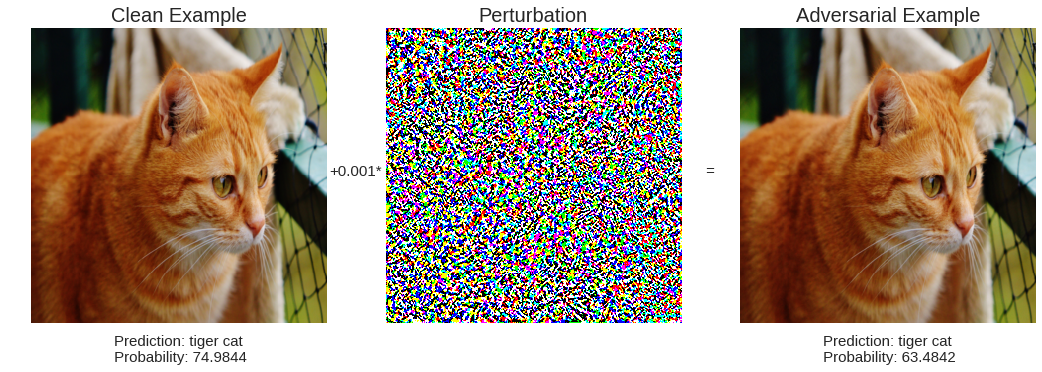

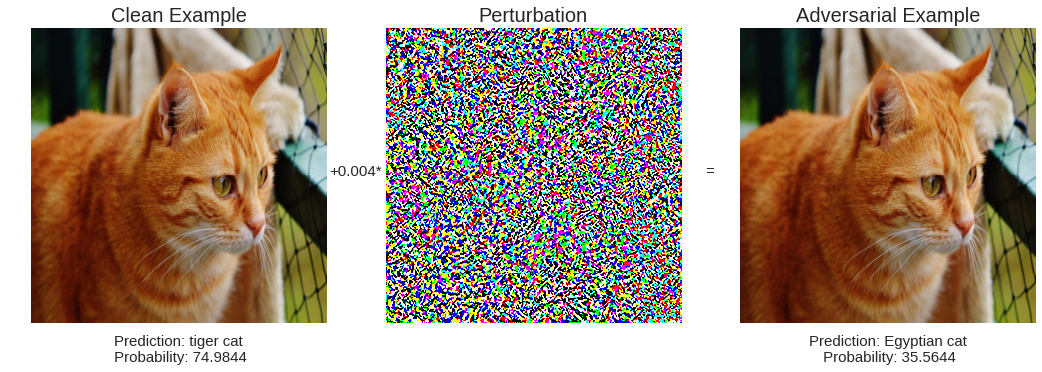

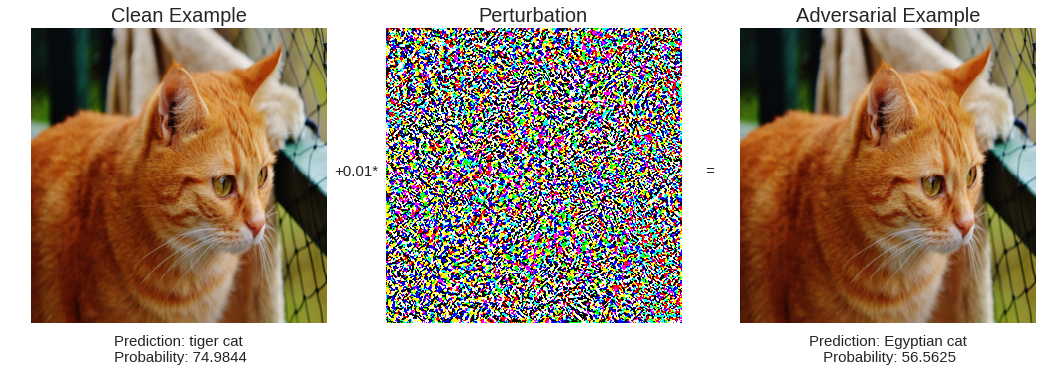

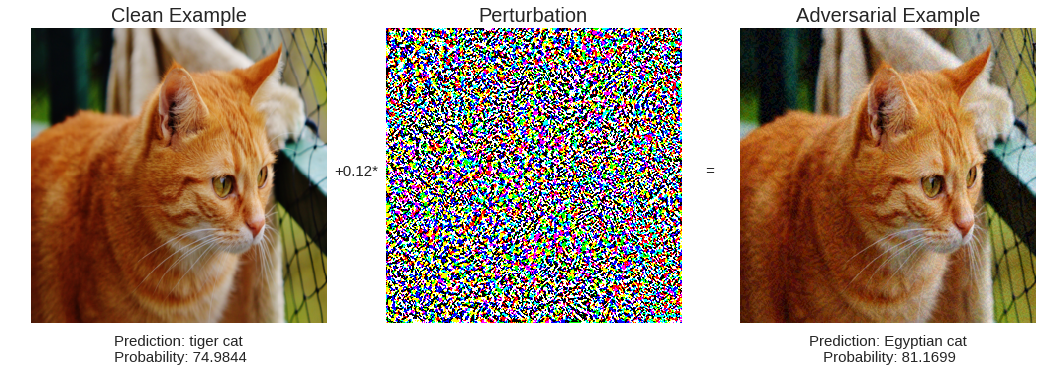

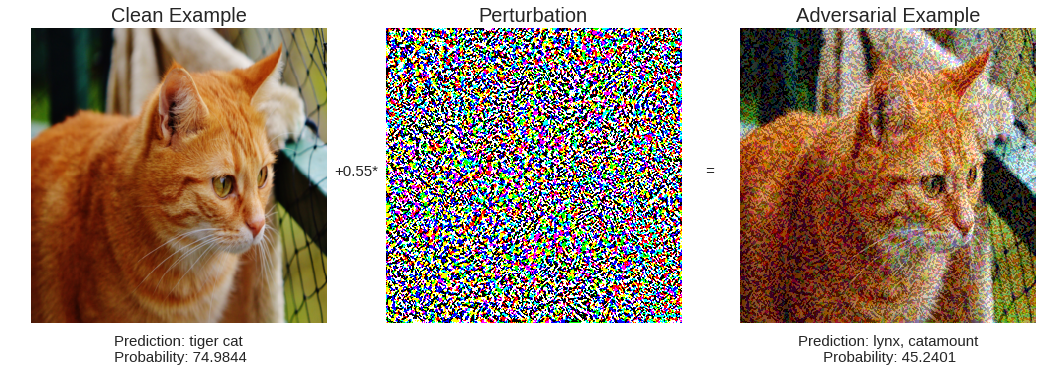

In [38]:
x_grad = torch.sign(img_variable.grad.data)
for i in epsilon:
  x_adversarial = img_variable.data + i * x_grad
  output_adv = inceptionv3.forward(Variable(x_adversarial))
  x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0]]
  op_adv_probs = F.softmax(output_adv, dim=1)
  adv_pred_prob =  round((torch.max(op_adv_probs.data, 1)[0][0]) * 100, 4)
  visualize(image_tensor, x_adversarial, x_grad, i, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)

<p style="font-size:18px; font-family:open sans; line-height:1.2">For very small value of epsilon, class doesn't change. But it decreases the probability. An alternative way is to use raw gradient (not sign) without any constraint (epsilon). It is called as Fast Gradient Value Method.


# One-step target class method

<p style="font-size:18px; font-family:open sans; line-height:1.5">As you might have noticed, FGSM find perturbation which increases the loss for the true class and subsequently that leads to misclassification. Also, FGSM is a non-targeted method. We can easily convert it into targeted method by maximizing probability $ P(\:Y_{target}\:|\:X\:)$ for some target class $Y_{target}$. For a neural network with cross-entropy loss the formula will be:
$$ X^{adv} = X - \epsilon sign(\nabla_X J(X, Y_{target})$$
The only change we need to make is that instead of adding perturbation to the original input, now we need to remove it from the original input. But, how to choose the target class? There are two ways. One is to use a random class as target class. Another and recommended way is to use class to which our model assigned lowest probability. It is also known as least likely class. Here, we will use random class.

In [40]:
#targeted class can be a random class or the least likely class predicted by the network
y_target = 288   #leopard
y_target = Variable(torch.LongTensor([y_target]), requires_grad=False)
print(y_target)

Variable containing:
 288
[torch.LongTensor of size 1]



In [0]:
zero_gradients(img_variable)                       #flush gradients
loss_cal2 = loss(output, y_target)
loss_cal2.backward()

In [0]:
epsilons = [0.002, 0.01, 0.15, 0.5 ]

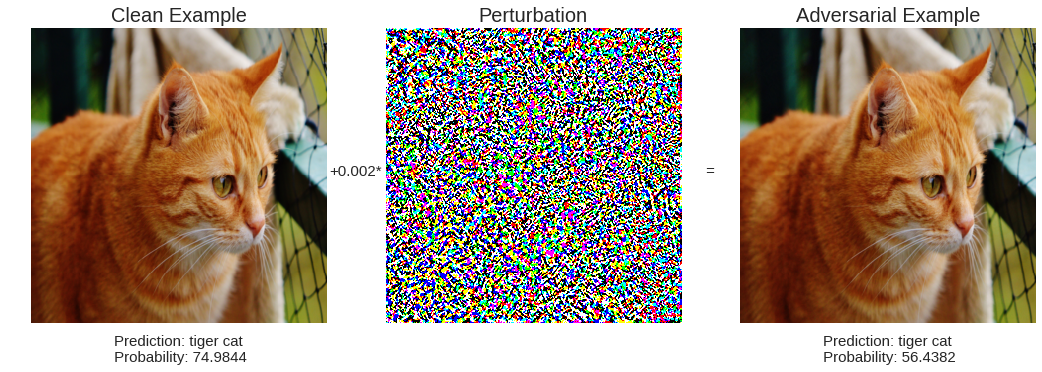

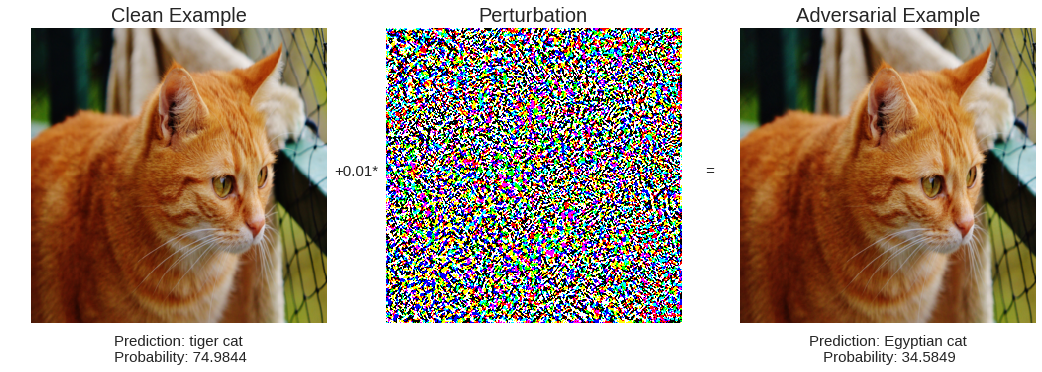

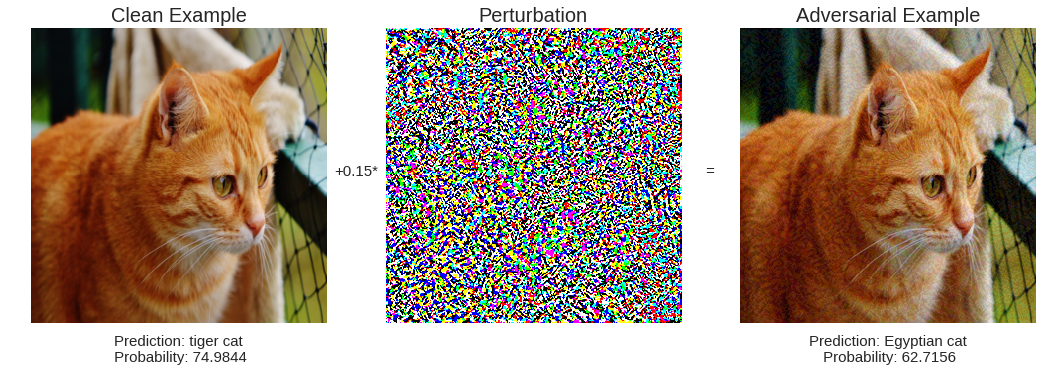

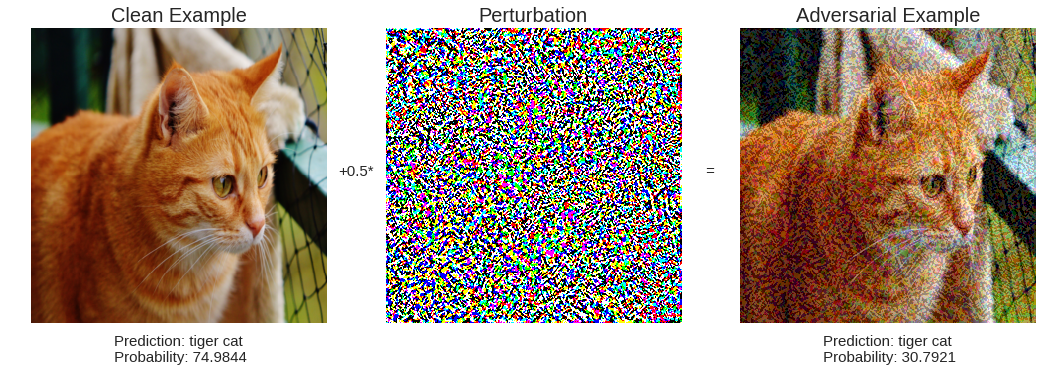

In [43]:
x_grad = torch.sign(img_variable.grad.data)
for i in epsilons:
  x_adversarial = img_variable.data - i * x_grad
  output_adv = inceptionv3.forward(Variable(x_adversarial))
  x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0]]
  op_adv_probs = F.softmax(output_adv, dim=1)
  adv_pred_prob =  round((torch.max(op_adv_probs.data, 1)[0][0]) * 100, 4)
  visualize(image_tensor, x_adversarial, x_grad, i, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)

<p style="font-size:18px; font-family:open sans; line-heigh:1.2"> Seems like it doesn't work well here. You may try with other images and results might change. Let's move on to other method and see if it can generate better adversarial examples.

# Basic Iterative Method

<p style="font-size:18px; font-family:open sans; line-heigh:1.2">Basic Iterative Method is an extension of FGSM method where it applied FGSM multiple times with small step size. We initialize adversarial image as an original image and then take one step along the direction of gradient during each iteration.
$$ X^{adv}_0 = X $$
$$ X^{adv}_{N+1} = Clip_{X, \:\epsilon}\:(\:X^{adv}_N\:+\:\alpha\:sign(\:\nabla_X J(X^{adv}_N, Y_{true}\:))$$

<p style="font-size:18px; font-family:open sans; line-heigh:1.2">Here, $Clip_{X, \epsilon}$ denotes clipping of input in the range of $[X - \epsilon, X + \epsilon]$

In [0]:
y_true = Variable( torch.LongTensor([282]), requires_grad=False)   #tiger cat
epsilon = 0.25
num_steps = 5
alpha = 0.025
#above three are hyperparameters

In [0]:
for i in range(num_steps):
  zero_gradients(img_variable)                       #flush gradients
  output = inceptionv3.forward(img_variable)         #perform forward pass
  loss = torch.nn.CrossEntropyLoss()
  loss_cal = loss(output, y_true)
  loss_cal.backward()
  x_grad = alpha * torch.sign(img_variable.grad.data)   # as per the formula
  adv_temp = img_variable.data + x_grad                 #add perturbation to img_variable which also contains perturbation from previous iterations
  total_grad = adv_temp - image_tensor                  #total perturbation
  total_grad = torch.clamp(total_grad, -epsilon, epsilon)
  x_adv = image_tensor + total_grad                      #add total perturbation to the original image
  img_variable.data = x_adv

#final adversarial example can be accessed at- img_variable.data

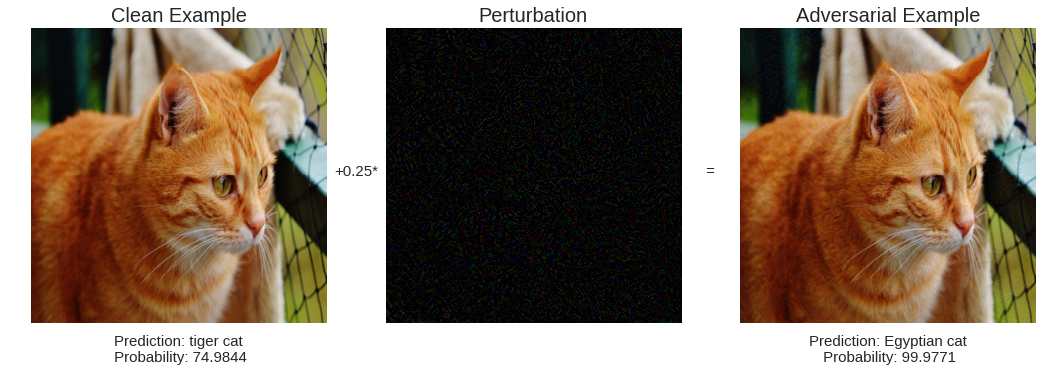

In [46]:
output_adv = inceptionv3.forward(img_variable)
x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0]]  #classify adversarial example
output_adv_probs = F.softmax(output_adv, dim=1)
x_adv_pred_prob =  round((torch.max(output_adv_probs.data, 1)[0][0]) * 100,4)
visualize(image_tensor, img_variable.data, total_grad, epsilon, x_pred,x_adv_pred, x_pred_prob,  x_adv_pred_prob)  #class and prob of original ex will remain same

<p style="font-size:18px; font-family:open sans; line-heigh:1.2">Looks great! Inceptionv3 classified it as Egyptian cat with more confidence than it has for the "tiger cat".

# Iterative Target Class Method

<p style="font-size:18px; font-family:open sans; line-heigh:1.2"> We can do the same for one-step target class method. As we show before, in order to make FGSM targeted we need to remove perturbation from original image. Here, we will do this for multiple iteration. Again note that it is recommended to use least likely class, but I am using random one. You can find least likely class by running `y_LL = torch.min(output.data, 1)[1][0]`

In [0]:
y_target = Variable(torch.LongTensor([9]), requires_grad=False)    #9= ostrich
epsilon = 0.25
num_steps = 5
alpha = 0.025


In [0]:
img_variable.data = image_tensor   #in previous method we assigned it to the adversarial img

In [0]:
for i in range(num_steps):
  zero_gradients(img_variable)
  output = inceptionv3.forward(img_variable)
  loss = torch.nn.CrossEntropyLoss()
  loss_cal = loss(output, y_target)
  loss_cal.backward()
  x_grad = alpha * torch.sign(img_variable.grad.data)
  adv_temp = img_variable.data - x_grad
  total_grad = adv_temp - image_tensor
  total_grad = torch.clamp(total_grad, -epsilon, epsilon)
  x_adv = image_tensor + total_grad
  img_variable.data = x_adv
  

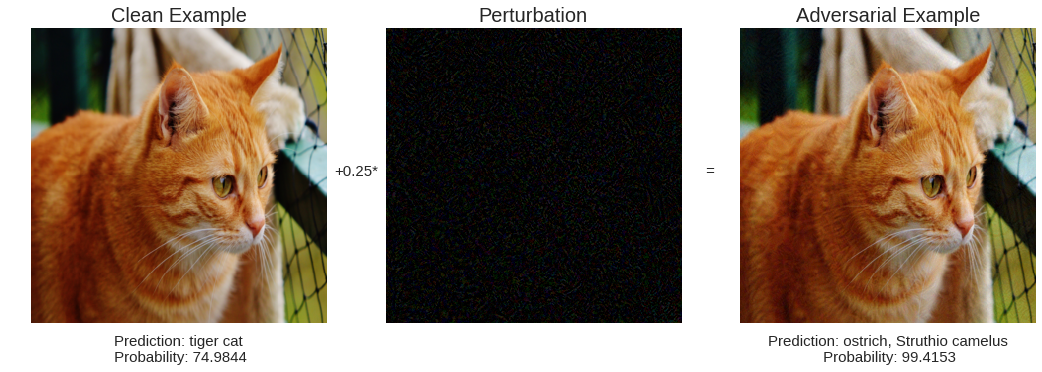

In [50]:
output_adv = inceptionv3.forward(img_variable)
x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0]]
output_adv_probs = F.softmax(output_adv, dim=1)
x_adv_pred_prob =  round((torch.max(output_adv_probs.data, 1)[0][0]) * 100,4)
visualize(image_tensor, img_variable.data, total_grad, epsilon, x_pred,x_adv_pred, x_pred_prob,  x_adv_pred_prob)

<p style="font-size:18px; font-family:open sans; line-heigh:1.2">As you can see, generated adversarial image looks same as the original image but our model classified it as an ostrich. I tried with several different target classes and it worked every time.<br><br>
The methods introduced here are very simple and efficient methods to generate adversarial examples. As you might have noticed, iterative methods produce better adversarial examples than one-step methods. There are other methods as well (DeepFool, Carlini & Wagner's Attack, Jacobian-based Saliency Map Attack, etc). There are also some methods (Defensive Distillation, Adversarial Training) to defend models against such attacks, which I will introduce in another notebook.